## Statistical methods and basic neural approaches

In this notebook we've done the statistical methods and the basic neural approaches when tackling the offensive language exploratory analysis.

All library imports are on the top and should be the first cell to be run.

In [13]:
#Required libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MaticF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MaticF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset preparation and basic methods

In this part we will preprocess the data and use some basic statistical methods on it.

In [4]:
#Starting dataset overview
path = "dataset.csv"
df = pd.read_csv(path,encoding='utf-8')
print(df)

               id  sentiment      target  \
0      hasoc_en_1       none         NaN   
1      hasoc_en_2       hate    targeted   
2      hasoc_en_3       none         NaN   
3      hasoc_en_4       none         NaN   
4      hasoc_en_5       none         NaN   
...           ...        ...         ...   
12647        5642    hateful      origin   
12648        5643    hateful       other   
12649        5644    hateful       other   
12650        5645    hateful  disability   
12651        5646  offensive      origin   

                                                    text      source  
0      #DhoniKeepsTheGlove | WATCH: Sports Minister K...  25_twitter  
1      @politico No. We should remember very clearly ...  25_twitter  
2      @cricketworldcup Guess who would be the winner...  25_twitter  
3      Corbyn is too politically intellectual for #Bo...  25_twitter  
4      All the best to #TeamIndia for another swimmin...  25_twitter  
...                                          

In [ ]:
def tokenize_and_stem_corpus(corpus):
    
    #For tokenizing we use the special TweetTokenizer which helps to take care of hashtags, mentions etc.
    token = TweetTokenizer()
    corpus["tokenized"] = corpus['text'].astype(str).apply(token.tokenize)
    prestemmed = corpus["tokenized"].tolist()
    
    #For stemming and stopwords we use the basic SnowballStemmer and the english stopwords
    stemmer = SnowballStemmer("english")
    stop = stopwords.words('english')
    
    #Array for holding stemmed sentences and the unique stems in this corpus
    stemmed = []
    unique = []
    
    for tokenized_sentence in prestemmed:
        filt = []
        for word in tokenized_sentence:
            #We remove all tokens which are hashtages, mentions or links and those which do not contain a letter
            if re.search('[a-zA-Z]', word) and not ("@" in word or "http" in word or "t.co" in word or "#" in word) and word not in stop:
                filt.append(word)
        
        #We stem the words        
        stems = [stemmer.stem(f) for f in filt]
        nstems = []
        
        for s in stems:
            #We remove the stop words
            if s not in stop:
                nstems.append(s)
        stemmed.append(nstems)
        
        for s in nstems:
            #Searching for all unique stems
            if s not in unique:
                unique.append(s)
    corpus["stemmed"] = stemmed
    return corpus, unique

def calculate_cond_frequencies(corpus):
    
    #Create a list of stems and sentiments
    sentiment = corpus["sentiment"].tolist()      
    stemmed = corpus["stemmed"].tolist()
    cfd = nltk.ConditionalFreqDist()
    
    #Iterate through all of them and update the frequencies
    for sent, stemmed_sentence in zip(sentiment,stemmed):
        for stem in stemmed_sentence:
            cfd[sent][stem] += 1
    
    return cfd

#Generalized calculate_cond_frequencies for n-grams
def extract_ngrams(corpus,n):
    
    sentiment = corpus["sentiment"].tolist()      
    stemmed = corpus["stemmed"].tolist()
    cfd = nltk.ConditionalFreqDist()
    
    for sent, stemmed_sentence in zip(sentiment,stemmed):
        ng = nltk.ngrams(stemmed_sentence,n)
        for gram in ng:
            cfd[sent][gram] += 1
    return cfd

#Calculates chi-square test for each label, which tells us how importantant is the word for the label (or in this case the stem)
def chi_square_test(corpus, unique):
    cfd = calculate_cond_frequencies(corpus)
    
    #The number we need to achieve for 95% CI
    meja = 3.84
    pomembne = []
    all_classes = list(cfd.keys())
    
    for key in cfd.keys():
        
        print(f"Current class: {key}")
        other_classes = []
        for o in all_classes:
            if o != key:
                other_classes.append(o)
        
        S = cfd.N()
        R = cfd[key].N()
        
        for u in unique:
            chi = 0

            a = cfd[key][u] if u in cfd[key] else 0
            b = sum([cfd[o][u] if u in cfd[o] else 0 for o in other_classes])
            
            #Pricakovana vrednost
            E = (a+b)/(S)
            #Opazovana vrednost
            O = (a)/R

            chi += ((O-E)**2)/E
            if chi > meja:
                print(u)
                pomembne.append((u,key))

    return pomembne

corpus = df[["text","sentiment"]]
corpus, unique = tokenize_and_stem_corpus(corpus)
cfd = calculate_cond_frequencies(corpus)

<ipython-input-17-18427595f062>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus["tokenized"] = corpus['text'].astype(str).apply(token.tokenize)


### Basic experiments

In [8]:
for i in range(1,4):
    ng_cfd = extract_ngrams(corpus,i)
    for k in ng_cfd.keys():
        print(f"3 most common {i}-grams for {k}: {ng_cfd[k].most_common(3)}")
    print("===========================================================")

3 most common 1-grams for none: [(('doctor',), 433), (('trump',), 295), (('peopl',), 245)]
3 most common 1-grams for hate: [(('peopl',), 99), (('muslim',), 96), (('trump',), 91)]
3 most common 1-grams for profanity: [(('fuck',), 279), (('trump',), 83), (('get',), 59)]
3 most common 1-grams for hateful: [(('u2026',), 356), (('retard',), 323), (('countri',), 236)]
3 most common 1-grams for abusive: [(('retard',), 157), (('u2026',), 119), (('ud83d',), 117)]
3 most common 1-grams for offensive: [(('retard',), 720), (('u2026',), 562), (('ud83d',), 456)]
3 most common 1-grams for disrespectful: [(('retard',), 42), (('u2026',), 40), (('countri',), 30)]
3 most common 1-grams for fearful: [(('retard',), 9), (('twat',), 8), (('n',), 7)]
3 most common 2-grams for none: [(('world', 'cup'), 137), (('bori', 'johnson'), 54), (('west', 'bengal'), 48)]
3 most common 2-grams for hate: [(('world', 'cup'), 45), (('bori', 'johnson'), 18), (('dhoni', 'glove'), 17)]
3 most common 2-grams for profanity: [(('w

In [11]:
chi_square_test(corpus,unique)

Trenutni klass: none
Trenutni klass: hate
Trenutni klass: profanity
Trenutni klass: hateful
Trenutni klass: abusive
Trenutni klass: offensive
Trenutni klass: disrespectful
Trenutni klass: fearful


[]

### Basic neural approaches

In this part we will present basic neural approaches such as Word2Vec and plot its embedding to see the relationship between the labels

<ipython-input-16-97e0bcb82f70>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  corpus_dict[k] = model[vocab]
<ipython-input-16-97e0bcb82f70>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  whole_corpus = model[whole_corpus]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA

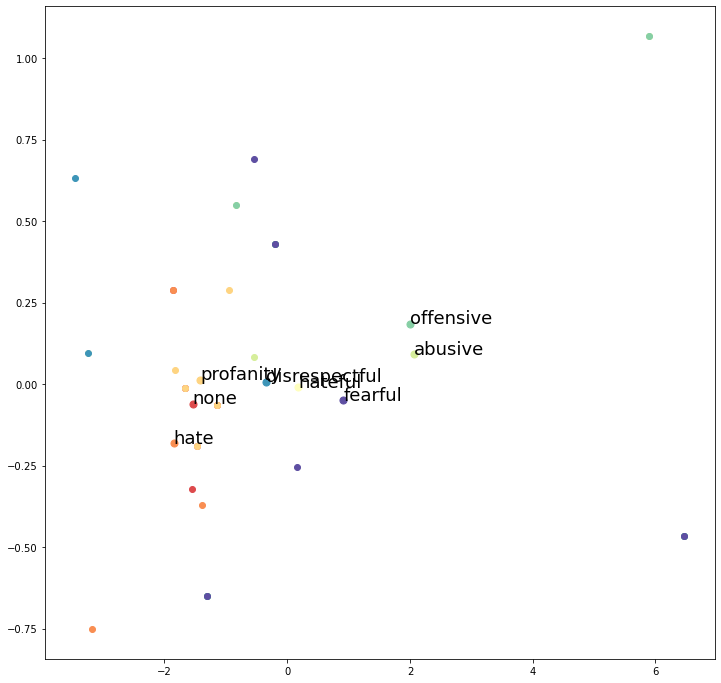

In [16]:
def extract_most_common_words(corpus,model,n):
    
    #Extracts n most common 1-grams for each label for the  corpus
    # whole_corpus has Word2Vec (or some others models) embeddings for all the words
    # Corpus_dict splits the values under the labels
    # words holds all the words
    cfd = calculate_cond_frequencies(corpus)
    whole_corpus = []
    corpus_dict = {}
    
    for k in cfd.keys():
        mc = cfd[k].most_common(n)

        vocab = []
        for w in mc:
            word = w[0]
            vocab.append(word)
            whole_corpus.append(word)
        corpus_dict[k] = model[vocab]
    
    words = whole_corpus
    whole_corpus = model[whole_corpus]
    return whole_corpus, corpus_dict, words

#Plots the embeddings decomposed by the PCA algorithm
def plot_word2vec(whole_corpus,corpus_dict, words):
    
    pca = PCA(n_components = 2)
    whole_corpus = pca.fit_transform(whole_corpus)
    
    plt.figure(1,figsize=(12,12))
    ct = 0
    ctc = 0
    cmap = plt.cm.get_cmap('Spectral')
    
    for k in corpus_dict.keys():
        
        x = pca.transform(corpus_dict[k])
        plt.scatter(x[:,0],x[:,1],c=cmap((ctc+1)/len(corpus_dict.keys())))
        x_povp = np.mean(x,axis=0)
        
        plt.scatter(x_povp[0],x_povp[1],50,c=cmap((ctc+1)/len(corpus_dict.keys())))
        plt.annotate(k,xy=(x_povp[0],x_povp[1]),size=18)
        ctc += 1
        
        for i in range(x.shape[0]):
            #plt.annotate(words[ct],xy=(x[i,0],x[i,1]))
            ct += 1
        

tokens = corpus["stemmed"].tolist()
model = gensim.models.Word2Vec(tokens,min_count=1)
whole_corpus, corpus_dict, words = extract_most_common_words(corpus,model,5)
plot_word2vec(whole_corpus,corpus_dict,words)